# 2D XRay registration demo
This demo is a toy example showing the usage of MONAI's registration capability.

The demo mainly uses
- a UNet-like registration network with an affine head to predict the affine transformation parameters;
- a warp function, implemented as a MONAI C++/CUDA module, to transform the moving image.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/master/2d_registration/registration_mednist.ipynb)

## Setup environment

`pip install` with the `BUILD_MONAI=1` flag will fetch the latest source code from the MONAI repository, build MONAI's C++/CUDA extensions, and install the package.

Setting `env BUILD_MONAI=1` indicates that when calling the relevant Python modules, MONAI will prefer those extensions instead of the Pytorch/Python native implementations.

(The compilation may take a few to 10+ minutes.)

In [ ]:
%env BUILD_MONAI=1

In [ ]:
!python -c "import monai" || pip install -q git+https://github.com/Project-MONAI/MONAI#egg=monai[all]

## Setup imports

In [2]:
from monai.utils import set_determinism, first
from monai.transforms import (
    EnsureChannelFirstD,
    Compose,
    LoadImageD,
    RandRotateD,
    RandZoomD,
    ScaleIntensityRanged,
    EnsureTypeD,
)
from monai.data import DataLoader, Dataset, CacheDataset
from monai.config import print_config, USE_COMPILED
from monai.networks.nets import GlobalNet
from monai.networks.blocks import Warp
from monai.apps import MedNISTDataset

import numpy as np
import torch
from torch.nn import MSELoss
import matplotlib.pyplot as plt
import os
import tempfile


print_config()
set_determinism(42)

MONAI version: 0.5.0+7.g9f4da6a
Numpy version: 1.19.5
Pytorch version: 1.8.1+cu101
MONAI flags: HAS_EXT = True, USE_COMPILED = True
MONAI rev id: 9f4da6acded249bba24c85eaee4ece256ed45815

Optional dependencies:
Pytorch Ignite version: 0.4.4
Nibabel version: 3.0.2
scikit-image version: 0.16.2
Pillow version: 7.1.2
Tensorboard version: 2.4.1
gdown version: 3.6.4
TorchVision version: 0.9.1+cu101
ITK version: 5.1.2
tqdm version: 4.60.0
lmdb version: 0.99
psutil version: 5.4.8

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [ ]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

# Construct pairwise training inputs
We use the `MedNISTDataset` object to download and unzip the actual data files.
Then we select the hand class, convert the loaded data dicts into "fixed_hand" and "moving_hand" which will be preprocessed differently to create synthetic training pairs.

In [3]:
train_data = MedNISTDataset(root_dir=root_dir, section="training", download=True, transform=None)
training_datadict = [
    {"fixed_hand": item["image"], "moving_hand": item["image"]}
    for item in train_data.data if item["label"] == 4  # label 4 is for xray hands
]
print("\n first training items: ", training_datadict[:3])

MedNIST.tar.gz: 59.0MB [00:07, 8.83MB/s]                            



downloaded file: ./MedNIST.tar.gz.
Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.


Loading dataset: 100%|██████████| 47164/47164 [00:00<00:00, 145309.19it/s]


 first training items:  [{'fixed_hand': './MedNIST/Hand/003696.jpeg', 'moving_hand': './MedNIST/Hand/003696.jpeg'}, {'fixed_hand': './MedNIST/Hand/001404.jpeg', 'moving_hand': './MedNIST/Hand/001404.jpeg'}, {'fixed_hand': './MedNIST/Hand/008882.jpeg', 'moving_hand': './MedNIST/Hand/008882.jpeg'}]


In [4]:
train_transforms = Compose(
    [
        LoadImageD(keys=["fixed_hand", "moving_hand"]),
        EnsureChannelFirstD(keys=["fixed_hand", "moving_hand"]),
        ScaleIntensityRanged(keys=["fixed_hand", "moving_hand"],
                             a_min=0., a_max=255., b_min=0.0, b_max=1.0, clip=True,),
        RandRotateD(keys=["moving_hand"], range_x=np.pi/4, prob=1.0, keep_size=True, mode="bicubic"),
        RandZoomD(keys=["moving_hand"], min_zoom=0.9, max_zoom=1.1, prob=1.0, mode="bicubic", align_corners=False),
        EnsureTypeD(keys=["fixed_hand", "moving_hand"]),
    ]
)

## Visualisation of the training pairs

moving_image shape: torch.Size([64, 64])
fixed_image shape: torch.Size([64, 64])


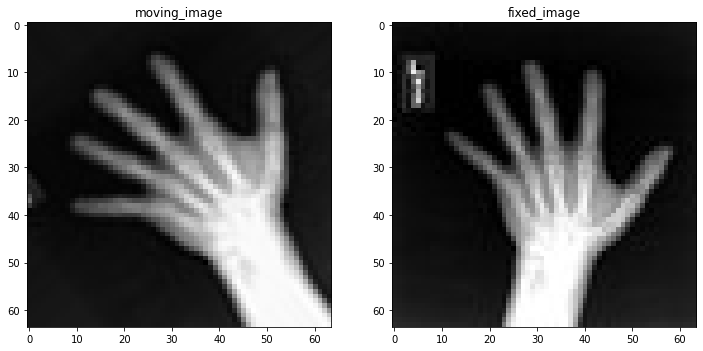

In [5]:
check_ds = Dataset(data=training_datadict, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=1, shuffle=True)
check_data = first(check_loader)
fixed_image = check_data["fixed_hand"][0][0]
moving_image = check_data["moving_hand"][0][0]

print(f"moving_image shape: {moving_image.shape}")
print(f"fixed_image shape: {fixed_image.shape}")

plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("moving_image")
plt.imshow(moving_image, cmap="gray")
plt.subplot(1, 2, 2)
plt.title("fixed_image")
plt.imshow(fixed_image, cmap="gray")

plt.show()

## Create the training pipelines
We use a `CacheDataset` to capture the training pairs and accelerate the training process.
The training data are fed into a `GlobalNet` which predicts image-level affine transformation parameters. A `Warp` layer is initialised and will be used for both training and inference.

In [6]:
train_ds = CacheDataset(data=training_datadict[:1000], transform=train_transforms,
                        cache_rate=1.0, num_workers=4)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=2)

Loading dataset: 100%|██████████| 1000/1000 [00:01<00:00, 558.34it/s]


In [7]:
device = torch.device("cuda:0")
model = GlobalNet(
    image_size=(64, 64),
    spatial_dims=2,
    in_channels=2,  # moving and fixed
    num_channel_initial=16,
    depth=3).to(device)
image_loss = MSELoss()
if USE_COMPILED:
    warp_layer = Warp(3, "border").to(device)
else:
    warp_layer = Warp("bilinear", "border").to(device)
optimizer = torch.optim.Adam(model.parameters(), 1e-5)

## The training loops

In [ ]:
max_epochs = 200
epoch_loss_values = []

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss, step = 0, 0
    for batch_data in train_loader:
        step += 1
        optimizer.zero_grad()

        moving = batch_data["moving_hand"].to(device)
        fixed = batch_data["fixed_hand"].to(device)
        ddf = model(torch.cat((moving, fixed), dim=1))
        pred_image = warp_layer(moving, ddf)

        loss = image_loss(pred_image, fixed)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        # print(f"{step}/{len(train_ds) // train_loader.batch_size}, "
        #       f"train_loss: {loss.item():.4f}")

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

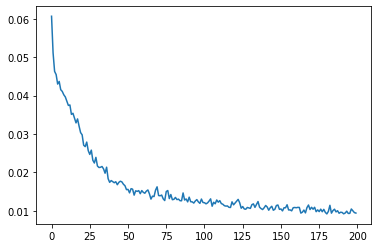

In [9]:
%matplotlib inline
plt.plot(epoch_loss_values)

# Visualise some validation results
This section creates a set of previously unseen pairs of moving vs fixed hands,
and use the network to predict the transformation between each pair.

In [10]:
val_ds = CacheDataset(data=training_datadict[2000:2500], transform=train_transforms,
                      cache_rate=1.0, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=16, num_workers=0)
for batch_data in val_loader:
    moving = batch_data["moving_hand"].to(device)
    fixed = batch_data["fixed_hand"].to(device)
    ddf = model(torch.cat((moving, fixed), dim=1))
    pred_image = warp_layer(moving, ddf)
    break

fixed_image = fixed.detach().cpu().numpy()[:, 0]
moving_image = moving.detach().cpu().numpy()[:, 0]
pred_image = pred_image.detach().cpu().numpy()[:, 0]

Loading dataset: 100%|██████████| 500/500 [00:00<00:00, 803.96it/s]


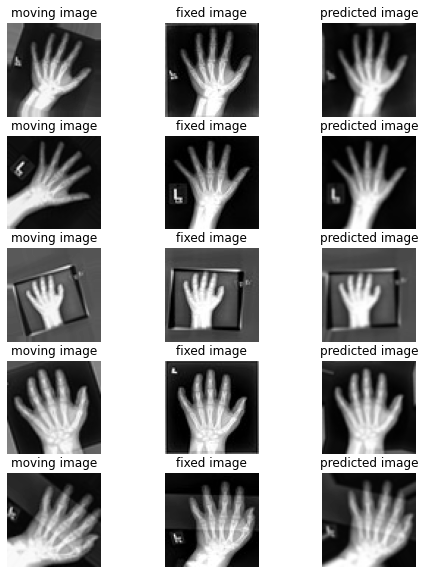

In [11]:
%matplotlib inline
batch_size = 5
plt.subplots(batch_size, 3, figsize=(8, 10))
for b in range(batch_size):
    # moving image
    plt.subplot(batch_size, 3, b * 3 + 1)
    plt.axis('off')
    plt.title("moving image")
    plt.imshow(moving_image[b], cmap="gray")
    # fixed image
    plt.subplot(batch_size, 3, b * 3 + 2)
    plt.axis('off')
    plt.title("fixed image")
    plt.imshow(fixed_image[b], cmap="gray")
    # warped moving
    plt.subplot(batch_size, 3, b * 3 + 3)
    plt.axis('off')
    plt.title("predicted image")
    plt.imshow(pred_image[b], cmap="gray")
plt.axis('off')
plt.show()